In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import classificacao

sns.set_style('darkgrid')
%matplotlib inline

/home/queimadas/.conda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Configura Modelo e teste com 70%-30%
df = pd.read_csv('conhecimento_filtrado.csv')

df_conhecimento = df[df.verifica.isin([1,3])]
print(df_conhecimento.shape)

# Gera amostra para teste
parte_30 = int((len(df_conhecimento)/100)*30)
ids_30 = np.random.choice(df_conhecimento.id, parte_30, replace=False)
teste_original = df_conhecimento[df_conhecimento.id.isin(ids_30)].copy().reset_index(drop=True)
teste = teste_original.copy()
teste['verifica'] = 0
print(len(teste_original))

# Modelo
modelo = df_conhecimento[~df_conhecimento.id.isin(ids_30)].copy()
print(len(modelo))
print(modelo.verifica.value_counts())

(71657, 13)
21497
50160
3    41161
1     8999
Name: verifica, dtype: int64


In [3]:
y_pred = classificacao.classifica(modelo, teste)
y_true = teste_original.sort_values('id').reset_index(drop=True)

Criando classificador RF
RF - Classifica dado usando as colunas ['medianb5', 'nbrl']
Classificando com NN
Cria avaliacao usando (RF+NN)/2 - Arredondado para 3 casas decimais


Confusion matrix, without normalization
[[ 2414  1480]
 [   57 17546]]
Normalized confusion matrix
[[0.61992809 0.38007191]
 [0.00323808 0.99676192]]


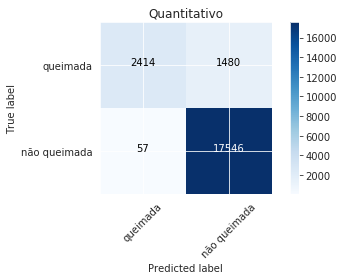

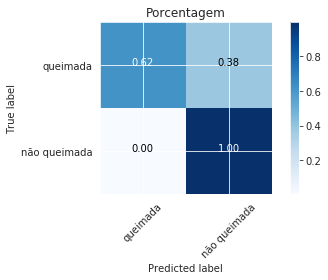

Acertos: 19960/21497 (92%)


In [4]:
classificacao.mostra_resultado(y_pred, y_true)